In [525]:
import warnings
warnings.filterwarnings('ignore')

## Import libraries

In [526]:
import numpy as np #vectors and matrices
import pandas as pd #tables and data manipulations
import matplotlib.pyplot as plt #plots
import seaborn as sns #more plots
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_squared_log_error

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [527]:
%matplotlib inline

## Import data

Import 5 years stock prices data and extract data of specific stock tickers such as Amazon (AMZN) and Tiffany's (TIFF). Store the data in dataframes

In [528]:
df = pd.read_csv('all_stocks_5yr.csv', usecols = ['date', 'change', "Name"], index_col=["date"], parse_dates=True)

In [529]:
# df2 = pd.read_csv('S&P Retail Select Industry Historical Data.csv',  index_col=['Date'], parse_dates=['Date'])

In [530]:
df2 = pd.read_csv('S&P Retail Select Industry Historical Data.csv', usecols = ['Date', 'Change'], index_col=["Date"], parse_dates=True)

In [531]:
cond = {'1' : 'AMZN', '2': 'TIF'}


In [532]:
amzn_data = df.loc[df.Name==cond['1'], ['change']]

In [533]:
tiff_data = df.loc[df.Name==cond['2'], ['change']]


In [534]:
# df2_t = pd.read_csv('S&P Retail Select Industry Historical Data.csv', usecols = ['Date', 'Change'], index_col=['Date'])

## Plot Data

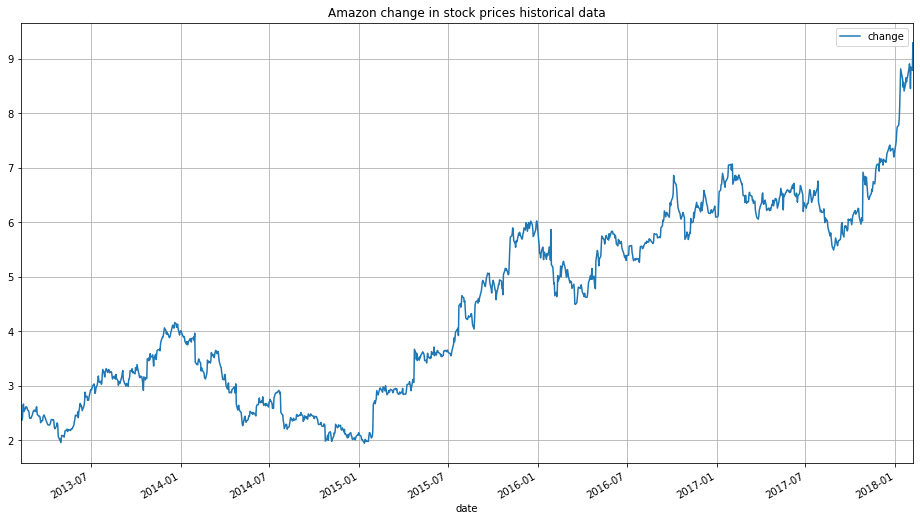

In [535]:
amzn_data.plot(figsize=(16,9), grid=True, title="Amazon change in stock prices historical data", label="Change %")

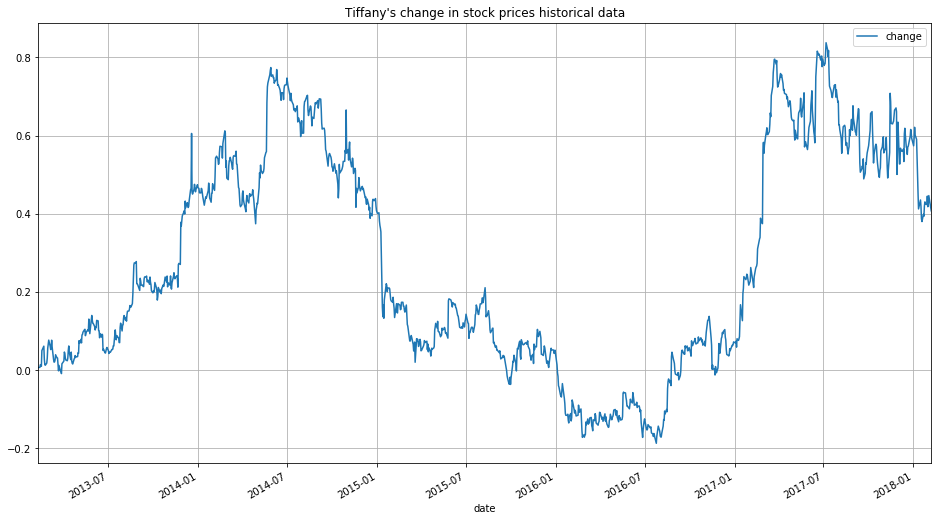

In [536]:
tiff_data.plot(figsize=(16,9), grid=True, title="Tiffany's change in stock prices historical data", label="Change %")

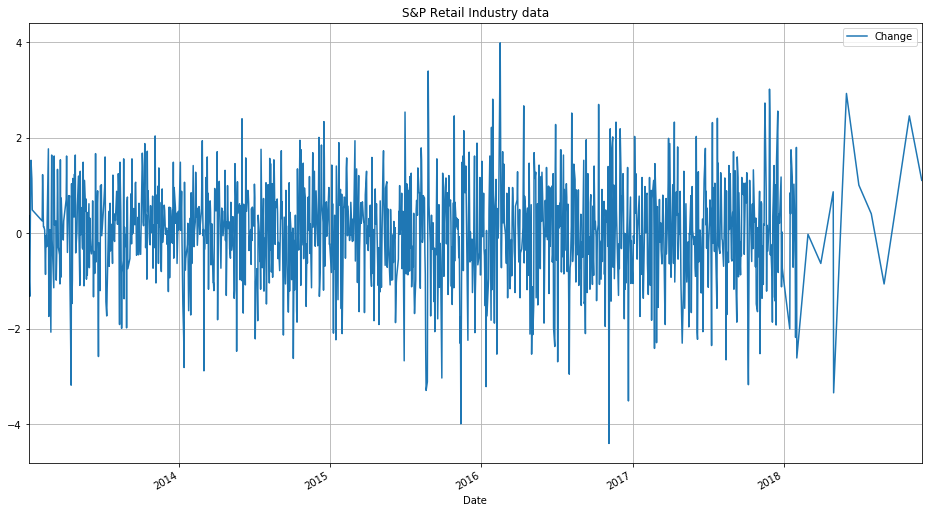

In [537]:
df2.plot(figsize=(16,9), grid=True, title="S&P Retail Industry data", label="Change %")

## Moving Average

Moving averages are used to smoothen the time series and identify trends.The wider the moving average window, the smoother the trend. In the case of very noisy data, which is often encountered in finance, this procedure can help detect common patterns.

In [538]:


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(16, 9))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #Plot confidence intervals for smooth values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation=np.std(series[window:]-rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")

        #Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bound] = series[series<lower_bound]
            anomalies[series>upper_bound] = series[series>upper_bound]
            plt.plot(anomalies, "ro", markersize=10)
    plt.plot(series[window:], label="Actual Values")
    plt.legend(loc="upper left")
    plt.grid(True)



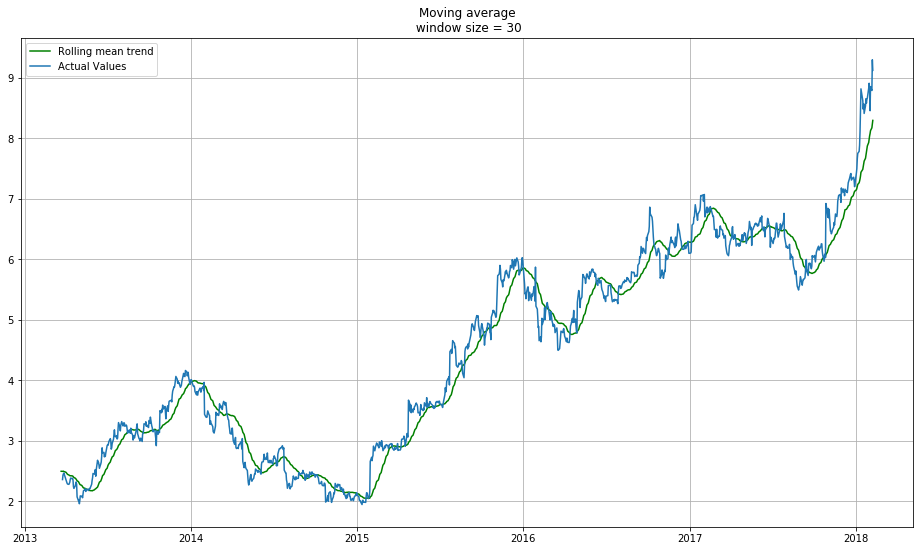

In [539]:
plotMovingAverage(amzn_data, 30, plot_intervals=False, plot_anomalies=False)

Inserting confidence intervals

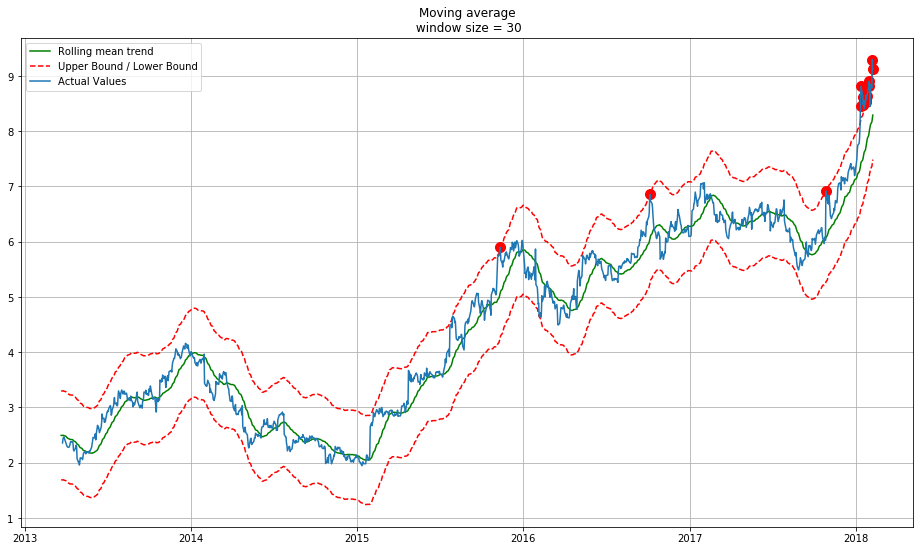

In [540]:
plotMovingAverage(amzn_data, 30, plot_intervals=True, plot_anomalies=True)

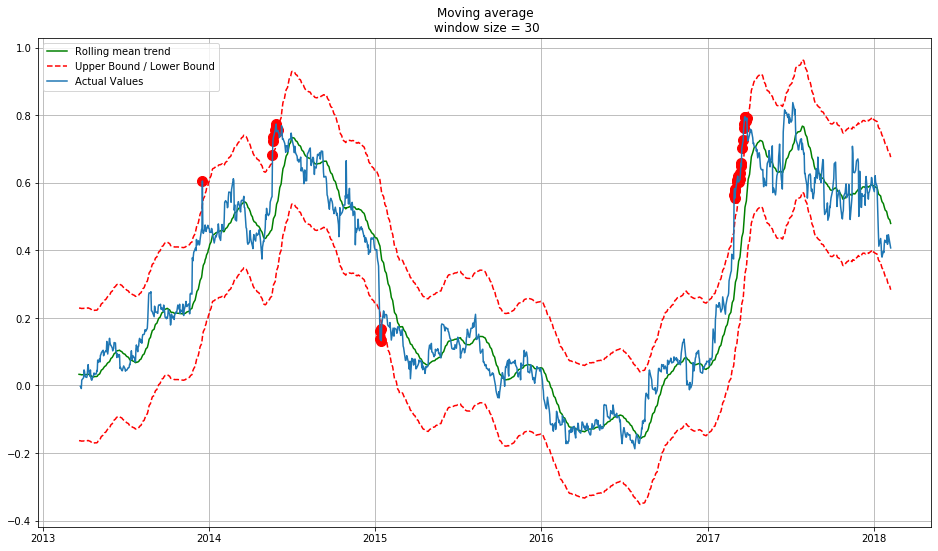

In [541]:
plotMovingAverage(tiff_data, 30, plot_intervals=True, plot_anomalies=True)

In [542]:
tiff_data['change'].corr(df2['Change'])

0.03356651284773405

In [543]:
amzn_data['change'].corr(df2['Change'])

-0.04537674321266832

In [544]:
# amzn_data.to_excel("S&P Retail Select Industry Historical Data.xlsx")

In [545]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [546]:
weighted_average(amzn_data, [0.6, 0.3, 0.1])

8.971621407894837

## Holt-Winter's model and Seasonality
Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component

In [547]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Time Series Cross validation

We need to estimate the model parameters automatically. We have to choose a loss function suitable for the task that will tell us how closely the model approximates the data. Then, using cross-validation, we will evaluate our chosen loss function for the given model parameters, calculate the gradient, adjust the model parameters, and so on, eventually descending to the global minimum.

In [548]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [549]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))



In [550]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# # amzn_data.index.freq = '1800T'
# train, test = amzn_data.change[:130, 0], df.change[130:, 0]
# model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
# pred = model.predict(start=test.index[0], end=test.index[-1])

# plt.plot(train.index, train, label='Train')
# plt.plot(test.index, test, label='Test')
# plt.plot(pred.index, pred, label='Holt-Winters')
# plt.legend(loc='best')

In [551]:
amzn_data(df2, axis = 0) 

TypeError: 'DataFrame' object is not callable